In [1]:
# ---------- 0. Imports ----------
import os, warnings, numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (f1_score, precision_score, recall_score,
                             accuracy_score, confusion_matrix)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from scipy.stats import randint, uniform

warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

Train: (4756, 31) Test: (4749, 30)
h1n1_vaccine
0    0.605971
1    0.394029
Name: proportion, dtype: float64


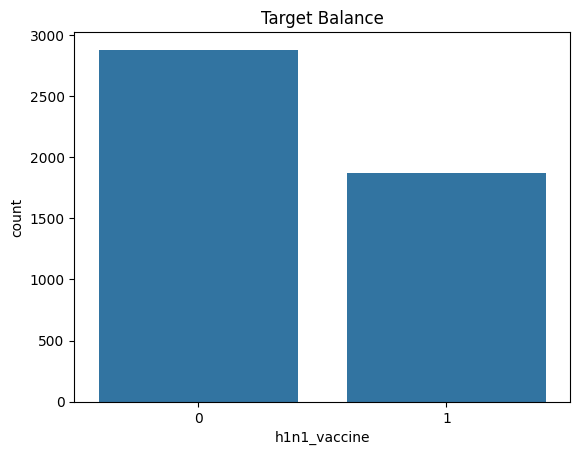

In [2]:
# ---------- 1. Load data ----------
train = pd.read_csv("dataset_B_training.csv")
test  = pd.read_csv("dataset_B_testing.csv")

# ---------- 2. Basic EDA ----------
print("Train:", train.shape, "Test:", test.shape)
print(train['h1n1_vaccine'].value_counts(normalize=True))

sns.countplot(x='h1n1_vaccine', data=train)
plt.title("Target Balance"); plt.show()

In [3]:
# ---------- 3. Feature groups ----------
cat_cols = ['age_group','education','race','sex','income_poverty','marital_status',
            'rent_or_own','employment_status','census_msa','employment_sector']
exclude = set(['respondent_id','h1n1_vaccine'] + cat_cols)
num_cols = [c for c in train.columns if c not in exclude]


In [5]:
# ---------- 4. Split ----------
X = train.drop(columns=['h1n1_vaccine'])
y = train['h1n1_vaccine'].astype(int)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

In [8]:
# ---------- 5. Preprocessing ----------
num_proc = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False))
])
cat_proc = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])
preprocess = ColumnTransformer([
    ('num', num_proc, num_cols),
    ('cat', cat_proc, cat_cols)
])

In [10]:
# ---------- 6. Models ----------
models = {
    "logreg": LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_STATE),
    "rf": RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1),
    "hgb": HistGradientBoostingClassifier(random_state=RANDOM_STATE),
    "extra": ExtraTreesClassifier(n_estimators=600, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1),
    "linsvc_cal": CalibratedClassifierCV(
        estimator=LinearSVC(class_weight='balanced', random_state=RANDOM_STATE),
        method='sigmoid', cv=3)
}
pipes = {n: Pipeline([('prep', preprocess), ('clf', m)]) for n, m in models.items()}

In [11]:
# ---------- 7. Helper: best threshold for F1 ----------
def best_threshold_for_f1(y_true, scores):
    x = scores
    if x.min() < 0 or x.max() > 1:
        x = (x - x.min()) / (x.max() - x.min() + 1e-9)
    thresholds = np.linspace(0.05, 0.95, 19)
    f1s = [f1_score(y_true, (x >= t).astype(int)) for t in thresholds]
    t_best = thresholds[np.argmax(f1s)]
    return float(t_best), float(max(f1s))

def evaluate(name, pipe):
    pipe.fit(X_train, y_train)
    if hasattr(pipe['clf'], "predict_proba"):
        scores = pipe.predict_proba(X_valid)[:,1]
    elif hasattr(pipe['clf'], "decision_function"):
        scores = pipe.decision_function(X_valid)
    else:
        scores = pipe.predict(X_valid)
    thr, _ = best_threshold_for_f1(y_valid, scores)
    y_pred = ( (scores - scores.min())/(scores.max()-scores.min()+1e-9) >= thr ).astype(int)
    return {
        "name": name,
        "threshold": thr,
        "F1_valid": f1_score(y_valid, y_pred),
        "precision": precision_score(y_valid, y_pred, zero_division=0),
        "recall": recall_score(y_valid, y_pred, zero_division=0),
        "accuracy": accuracy_score(y_valid, y_pred)
    }

# ---------- 8. Train & evaluate all 5 ----------
results = [evaluate(n,p) for n,p in pipes.items()]
results_sorted = sorted(results, key=lambda r: r["F1_valid"], reverse=True)

# ---------- (A) Leaderboard ----------
leaderboard = pd.DataFrame(results_sorted)
print("\n=== Leaderboard (validation) ===")
display(leaderboard.style.background_gradient(cmap='Blues'))

# ---------- (B) Hyper-parameter tuning for top model ----------
best_name = results_sorted[0]['name']
print("\nTuning top model:", best_name)
grid = {}

if best_name == "rf" or best_name == "extra":
    grid = {
        "clf__n_estimators": randint(300, 1200),
        "clf__max_depth": randint(4, 40),
        "clf__min_samples_split": randint(2, 10),
        "clf__min_samples_leaf": randint(1, 6)
    }
elif best_name == "logreg":
    grid = {
        "clf__C": uniform(0.01, 10.0),
        "clf__solver": ["lbfgs", "saga"]
    }
elif best_name == "hgb":
    grid = {
        "clf__max_depth": randint(2, 20),
        "clf__learning_rate": uniform(0.01, 0.3),
        "clf__l2_regularization": uniform(0.0, 1.0)
    }

if grid:
    tuned = RandomizedSearchCV(
        estimator=pipes[best_name],
        param_distributions=grid,
        n_iter=25, scoring="f1",
        cv=3, random_state=RANDOM_STATE, n_jobs=-1, verbose=1
    )
    tuned.fit(X_train, y_train)
    print("\nBest CV-F1:", tuned.best_score_)
    print("Best parameters:", tuned.best_params_)
else:
    print("No tuning grid defined for this model.")


=== Leaderboard (validation) ===


,name,threshold,F1_valid,precision,recall,accuracy
0,logreg,0.400000,0.690286,0.604000,0.805333,0.715336
1,linsvc_cal,0.350000,0.685030,0.621739,0.762667,0.723739
2,rf,0.400000,0.679151,0.638498,0.725333,0.730042
3,hgb,0.350000,0.678175,0.630734,0.733333,0.725840
4,extra,0.400000,0.677460,0.635514,0.725333,0.727941



Tuning top model: logreg
Fitting 3 folds for each of 25 candidates, totalling 75 fits

Best CV-F1: 0.7053884487231697
Best parameters: {'clf__C': np.float64(3.0561376917337064), 'clf__solver': 'lbfgs'}


In [12]:
# ---------- 9. Retrain top-5 on full data & export submissions ----------
os.makedirs("submissions", exist_ok=True)
X_full, y_full = X, y

for rank, r in enumerate(results_sorted[:5], start=1):
    mname = r["name"]
    model = models[mname]
    pipe = Pipeline([('prep', preprocess), ('clf', model)])
    pipe.fit(X_full, y_full)

    if hasattr(pipe['clf'], "predict_proba"):
        s = pipe.predict_proba(test)[:,1]
        y_pred = ( (s - s.min())/(s.max()-s.min()+1e-9) >= r["threshold"] ).astype(int)
    elif hasattr(pipe['clf'], "decision_function"):
        d = pipe.decision_function(test)
        y_pred = ( (d - d.min())/(d.max()-d.min()+1e-9) >= r["threshold"] ).astype(int)
    else:
        y_pred = pipe.predict(test)

    sub = pd.DataFrame({"respondent_id": test['respondent_id'], "h1n1_vaccine": y_pred})
    fname = f"challenge_submission_groupB_order{rank}_{mname}_F1_{r['F1_valid']:.4f}.csv"
    sub.to_csv(os.path.join("submissions", fname), index=False)
    print("Saved:", fname)


Saved: challenge_submission_groupB_order1_logreg_F1_0.6903.csv
Saved: challenge_submission_groupB_order2_linsvc_cal_F1_0.6850.csv
Saved: challenge_submission_groupB_order3_rf_F1_0.6792.csv
Saved: challenge_submission_groupB_order4_hgb_F1_0.6782.csv
Saved: challenge_submission_groupB_order5_extra_F1_0.6775.csv


In [13]:
# ---------- 10. Optional: CV check for top model ----------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_f1 = cross_val_score(pipes[best_name], X, y, scoring='f1', cv=cv, n_jobs=-1)
print(f"\n{best_name} 5-fold CV-F1: {cv_f1.mean():.4f} ± {cv_f1.std():.4f}")


logreg 5-fold CV-F1: 0.7011 ± 0.0150


In [ ]:
# --- 6. Define 10 models ---
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

models = {
    # previous 5
    "logreg": LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_STATE),
    "rf": RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1),
    "hgb": HistGradientBoostingClassifier(random_state=RANDOM_STATE),
    "extra": ExtraTreesClassifier(n_estimators=600, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1),
    "linsvc_cal": CalibratedClassifierCV(
        estimator=LinearSVC(class_weight='balanced', random_state=RANDOM_STATE),
        method='sigmoid', cv=3
    ),
    # new 5
    "xgb": XGBClassifier(
        n_estimators=600, max_depth=6, learning_rate=0.05, subsample=0.9,
        colsample_bytree=0.8, reg_lambda=1.0, objective="binary:logistic",
        eval_metric="logloss", random_state=RANDOM_STATE, n_jobs=-1
    ),
    "lgbm": LGBMClassifier(
        n_estimators=800, max_depth=-1, num_leaves=63, subsample=0.9,
        colsample_bytree=0.8, learning_rate=0.05, class_weight='balanced',
        random_state=RANDOM_STATE, n_jobs=-1
    ),
    "cat": CatBoostClassifier(
        iterations=800, depth=6, learning_rate=0.05, l2_leaf_reg=3.0,
        loss_function='Logloss', verbose=False, random_state=RANDOM_STATE, thread_count=-1
    ),
    "gbc": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "dt": DecisionTreeClassifier(max_depth=None, class_weight='balanced', random_state=RANDOM_STATE)
}

pipes = {name: Pipeline([('prep', preprocess), ('clf', model)]) for name, model in models.items()}

# --- 7. F1 threshold tuning helper ---
def best_threshold_for_f1(y_true, scores):
    # scores can be probas or decision values; normalize if needed
    s = scores.astype(float)
    s_min, s_max = s.min(), s.max()
    if (s_min < 0) or (s_max > 1):
        s = (s - s_min) / (s_max - s_min + 1e-9)
    thresholds = np.linspace(0.05, 0.95, 19)
    f1s = []
    for t in thresholds:
        preds = (s >= t).astype(int)
        f1s.append((t, f1_score(y_true, preds)))
    t_best, f1_best = max(f1s, key=lambda z: z[1])
    return float(t_best), float(f1_best)

def evaluate_model(name, pipe):
    pipe.fit(X_train, y_train)
    if hasattr(pipe['clf'], "predict_proba"):
        scores = pipe.predict_proba(X_valid)[:, 1]
    elif hasattr(pipe['clf'], "decision_function"):
        scores = pipe.decision_function(X_valid)
    else:
        # fallback hard predictions (rare here)
        preds = pipe.predict(X_valid)
        return {
            "name": name,
            "threshold": 0.5,
            "F1_valid": f1_score(y_valid, preds),
            "precision": precision_score(y_valid, preds, zero_division=0),
            "recall": recall_score(y_valid, preds, zero_division=0),
            "accuracy": accuracy_score(y_valid, preds)
        }
    thr, _ = best_threshold_for_f1(y_valid, scores)
    s_min, s_max = scores.min(), scores.max()
    s_norm = (scores - s_min) / (s_max - s_min + 1e-9)
    y_pred = (s_norm >= thr).astype(int)
    return {
        "name": name,
        "threshold": thr,
        "F1_valid": f1_score(y_valid, y_pred),
        "precision": precision_score(y_valid, y_pred, zero_division=0),
        "recall": recall_score(y_valid, y_pred, zero_division=0),
        "accuracy": accuracy_score(y_valid, y_pred)
    }

# --- 8. Train & evaluate all 10 models ---
results = []
for name, pipe in pipes.items():
    print(f"Training: {name}")
    res = evaluate_model(name, pipe)
    results.append(res)
    print(f" -> F1={res['F1_valid']:.4f} | P={res['precision']:.4f} | R={res['recall']:.4f} | Acc={res['accuracy']:.4f}")

# Rank by F1
results_sorted = sorted(results, key=lambda r: r["F1_valid"], reverse=True)

# --- (A) Leaderboard table ---
leaderboard = pd.DataFrame(results_sorted)
print("\n=== Leaderboard (Validation) ===")
display(leaderboard.style.background_gradient(cmap='Blues'))

# --- (B) Hyper-parameter tuning for the current #1 model ---
from scipy.stats import randint, uniform

best_name = results_sorted[0]['name']
print("\nTop model for tuning:", best_name)

tune_grid = {}
if best_name == "rf" or best_name == "extra":
    tune_grid = {
        "clf__n_estimators": randint(400, 1400),
        "clf__max_depth": randint(4, 40),
        "clf__min_samples_split": randint(2, 12),
        "clf__min_samples_leaf": randint(1, 6)
    }
elif best_name == "logreg":
    tune_grid = {
        "clf__C": uniform(0.01, 10.0),
        "clf__solver": ["lbfgs", "saga"]
    }
elif best_name == "hgb":
    tune_grid = {
        "clf__max_depth": randint(3, 24),
        "clf__learning_rate": uniform(0.01, 0.3),
        "clf__l2_regularization": uniform(0.0, 1.0)
    }
elif best_name == "xgb":
    tune_grid = {
        "clf__n_estimators": randint(400, 1200),
        "clf__max_depth": randint(3, 10),
        "clf__learning_rate": uniform(0.01, 0.2),
        "clf__subsample": uniform(0.6, 0.4),
        "clf__colsample_bytree": uniform(0.6, 0.4),
        "clf__reg_lambda": uniform(0.0, 2.0)
    }
elif best_name == "lgbm":
    tune_grid = {
        "clf__n_estimators": randint(400, 1400),
        "clf__num_leaves": randint(31, 127),
        "clf__learning_rate": uniform(0.01, 0.2),
        "clf__subsample": uniform(0.6, 0.4),
        "clf__colsample_bytree": uniform(0.6, 0.4)
    }
elif best_name == "cat":
    tune_grid = {
        "clf__iterations": randint(400, 1400),
        "clf__depth": randint(4, 10),
        "clf__learning_rate": uniform(0.01, 0.2),
        "clf__l2_leaf_reg": uniform(1.0, 5.0)
    }
elif best_name == "gbc":
    tune_grid = {
        "clf__n_estimators": randint(200, 1000),
        "clf__learning_rate": uniform(0.01, 0.2),
        "clf__max_depth": randint(2, 8)
    }
elif best_name == "dt":
    tune_grid = {
        "clf__max_depth": randint(3, 40),
        "clf__min_samples_split": randint(2, 20),
        "clf__min_samples_leaf": randint(1, 10)
    }
elif best_name == "linsvc_cal":
    tune_grid = {
        "clf__base_estimator__C": uniform(0.1, 5.0)
    }

if tune_grid:
    tuned = RandomizedSearchCV(
        estimator=pipes[best_name],
        param_distributions=tune_grid,
        n_iter=30, scoring="f1", cv=3,
        random_state=RANDOM_STATE, n_jobs=-1, verbose=1
    )
    tuned.fit(X_train, y_train)
    print("\nBest CV-F1:", tuned.best_score_)
    print("Best params:", tuned.best_params_)

    # Evaluate tuned on validation with F1-threshold optimization
    # (reuse evaluator by passing the already-fit estimator)
    tuned_pipe = tuned.best_estimator_
    if hasattr(tuned_pipe['clf'], "predict_proba"):
        scr = tuned_pipe.predict_proba(X_valid)[:, 1]
    elif hasattr(tuned_pipe['clf'], "decision_function"):
        scr = tuned_pipe.decision_function(X_valid)
    else:
        scr = tuned_pipe.predict(X_valid)

    thr_tuned, _ = best_threshold_for_f1(y_valid, scr)
    s_min, s_max = scr.min(), scr.max()
    s_norm = (scr - s_min) / (s_max - s_min + 1e-9)
    preds_tuned = (s_norm >= thr_tuned).astype(int)
    print(f"Tuned {best_name}  -> F1_valid={f1_score(y_valid, preds_tuned):.4f}  thr={thr_tuned:.3f}")
else:
    print("No tuning grid for the top model (skipped).")

# --- 9. Optional: 5-fold CV on the #1 model (sanity check) ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_f1 = cross_val_score(pipes[best_name], X, y, scoring='f1', cv=cv, n_jobs=-1)
print(f"\n{best_name} 5-fold CV-F1: {cv_f1.mean():.4f} ± {cv_f1.std():.4f}")

# --- 10. OPTIONAL submissions (only if test CSV is present) ---
if test is not None:
    os.makedirs("submissions", exist_ok=True)
    # retrain each of the top 5 on full training data, then predict test with tuned threshold from validation
    for rank, r in enumerate(results_sorted[:5], start=1):
        mname = r["name"]
        model = models[mname]
        pipe = Pipeline([('prep', preprocess), ('clf', model)])
        pipe.fit(X, y)

        # get scores on test
        if hasattr(pipe['clf'], "predict_proba"):
            s = pipe.predict_proba(test)[:, 1]
        elif hasattr(pipe['clf'], "decision_function"):
            s = pipe.decision_function(test)
        else:
            # hard predictions
            preds = pipe.predict(test).astype(int)
            sub = pd.DataFrame({"respondent_id": test["respondent_id"], "h1n1_vaccine": preds})
            fname = f"challenge_submission_groupB_order{rank}_{mname}_F1_{r['F1_valid']:.4f}.csv"
            sub.to_csv(os.path.join("submissions", fname), index=False)
            print("Saved:", fname)
            continue

        # normalize & threshold using validation-optimal threshold for that model
        s_min, s_max = s.min(), s.max()
        s_norm = (s - s_min) / (s_max - s_min + 1e-9)
        preds = (s_norm >= r["threshold"]).astype(int)

        sub = pd.DataFrame({"respondent_id": test["respondent_id"], "h1n1_vaccine": preds})
        fname = f"challenge_submission_groupB_order{rank}_{mname}_F1_{r['F1_valid']:.4f}.csv"
        sub.to_csv(os.path.join("submissions", fname), index=False)
        print("Saved:", fname)
else:
    print("\nNo testing CSV found — training/validation complete. (This matches your professor’s plan.)")

Training: logreg
 -> F1=0.6903 | P=0.6040 | R=0.8053 | Acc=0.7153
Training: rf
 -> F1=0.6792 | P=0.6385 | R=0.7253 | Acc=0.7300
Training: hgb
 -> F1=0.6782 | P=0.6307 | R=0.7333 | Acc=0.7258
Training: extra
 -> F1=0.6775 | P=0.6355 | R=0.7253 | Acc=0.7279
Training: linsvc_cal
 -> F1=0.6850 | P=0.6217 | R=0.7627 | Acc=0.7237
Training: xgb
 -> F1=0.6732 | P=0.6261 | R=0.7280 | Acc=0.7216
Training: lgbm
[LightGBM] [Info] Number of positive: 1499, number of negative: 2305
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 149
[LightGBM] [Info] Number of data points in the train set: 3804, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
 -> F1=0.6744 | P=0.5979 | R=0.7733 | Acc=

,name,threshold,F1_valid,precision,recall,accuracy
0,gbc,0.350000,0.691839,0.636771,0.757333,0.734244
1,logreg,0.400000,0.690286,0.604000,0.805333,0.715336
2,linsvc_cal,0.350000,0.685030,0.621739,0.762667,0.723739
3,rf,0.400000,0.679151,0.638498,0.725333,0.730042
4,hgb,0.350000,0.678175,0.630734,0.733333,0.725840
5,extra,0.400000,0.677460,0.635514,0.725333,0.727941
6,lgbm,0.250000,0.674419,0.597938,0.773333,0.705882
7,xgb,0.350000,0.673243,0.626147,0.728000,0.721639
8,cat,0.200000,0.668790,0.555556,0.840000,0.672269
9,dt,0.050000,0.579974,0.565990,0.594667,0.660714



Top model for tuning: gbc
Fitting 3 folds for each of 30 candidates, totalling 90 fits


In [17]:
%pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.7 MB/s eta 0:00:00


After installing the library, please re-run the previous cell to continue with the model training and evaluation.